In [1]:
import sys
from xmlrpc.server import SimpleXMLRPCServer, SimpleXMLRPCRequestHandler
import socketserver
import xmlrpc.client
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
import matplotlib.pyplot as plt

import copy
from sklearn.model_selection import ParameterGrid

%matplotlib inline

C:\Users\nbbwang\Anaconda2\envs\py36\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
max_epochs = 200
running_avg_window = 2
slopes_window = 4
min_observations = 3
tolerance_eps = 5

loss_quantile_cutoff = .5
slope_quantile_cutoff = .5


num_workers = 3

In [3]:
HY_COMBOS = {
     # each element of conv_layers should be tuple:
     #(num filters, filtersize tuple, poolsize tuple OR none if not pooling)
    "conv_layers": [[(32,(3,3),(2, 2)), (10,(3,3),(2,2))], [(32,(3,3),(2, 2))],[]],
    # this is a list of sizes for each dense layer
    # do not include the final prediction layer here
    "dense_layers" : [[50,10,5], [40,20],[10],[]],
    # apply the SAME activation and dropout to every conv and dense layer 
    # (except for final output which has hardcoded softmax activation w/ no dropout)
    "activation": ["relu", "sigmoid"], 
    "dropout":  np.arange(0,.5,.1),
    # l2 regularization for weights
    "k_reg": [0,.001],
    # optimization hyperparameters
    "learning_rate": [.01],
    "grad_clip_norm": np.arange(0,.5,.2)}
    
    
hy_list = list(ParameterGrid(HY_COMBOS)) 


#FOR SIMULATION
noise = .1
TRAINING_CURVES = np.array([
    [100 - x**.1 + noise*np.random.randn() for x in range(max_epochs)],
    [100 - x**.1 + noise*np.random.randn() for x in range(max_epochs)],
    [100 - x**.2 + noise*np.random.randn() for x in range(max_epochs)],
    [100 - 2*x**.1 + noise*np.random.randn()for x in range(max_epochs)],
    [100 - 1.5*x**.2 + noise*np.random.randn() for x in range(max_epochs)],
    [100 - 3*x**.1 + noise*np.random.randn() for x in range(max_epochs)],
    [100 - 3*x**.15 + .1*np.random.randn()  for x in range(max_epochs)],
    [100 - 3.5*x**.15 + .1*np.random.randn()  for x in range(max_epochs)],
    [100 - 5*x**.1 + .1*np.random.randn() for x in range(max_epochs)],
    [100 - 4*x**.15  + .1*np.random.randn()for x in range(max_epochs)],
    [100 - 5*x**.11  + .1*np.random.randn()for x in range(max_epochs)]
])

hy_list = copy.copy(TRAINING_CURVES)



print("Total combos:", len(hy_list))

Total combos: 11


In [4]:
# INITIALIZATION 
losses = np.empty([len(hy_list), max_epochs])
losses.fill(np.nan)

running_averages = np.empty([len(hy_list), max_epochs])
running_averages.fill(np.nan)

running_slopes = np.empty([len(hy_list), max_epochs])
running_slopes.fill(np.nan)

# here, we're just pre-specifying a random order in which to test all the hyperparameters 
MODEL_QUEUE = list(np.random.permutation(len(hy_list)))



# array of length num_workers 
# --> if the worker is idle, value is np.nan; otherwise, the value is the model number that's being trained
WORKERS = np.empty(num_workers)
WORKERS.fill(np.nan)


# For the simulation, We randomly pick a worker to "receive" a message from, but in reality we just select data from 
# the pre-determined training curve and pass it to the update function 
# ep_counters is used to keep track of what epoch we're up to in training  
# (it's a dict where each key is a model number and the value is the #epoch training is thought to be on)
ep_counters = {}
for mod in range(len(TRAINING_CURVES)):
    ep_counters[mod] = 0

In [5]:
# this is probably not robust to message dropping -- to make it so, we should also update the running avg for any future values
# (this would be necessary in the case where we receive a message from epoch i after another message from epoch i+1)
def update(epoch_num, model_num, loss):
    # update loss value
    losses[model_num, epoch_num] = loss
    
    # keep running average for the slopes --> then update the slope
    # if statements prevent us from indexing into negative indices of the array 
    if epoch_num - running_avg_window + 1 >= 0:
        running_averages[model_num, epoch_num] = np.mean(losses[model_num, epoch_num-running_avg_window+1:epoch_num+1])
    if epoch_num - slopes_window >= 0:
        running_slopes[model_num, epoch_num] = running_averages[model_num, epoch_num] - running_averages[model_num, epoch_num-slopes_window]
    return



def check_stopping(model_num):
    # get the epochs for the current model that is not nan (i.e., avoid errors if we have dropped messages)
    mod_non_nan_loss_eps = np.where(~np.isnan(losses[model_num]))[0]
    
    # if there are not enough epochs run to make a decision, skip all of this and return False
    if len(mod_non_nan_loss_eps) >= tolerance_eps: 
        
        # select chunk of loss matrix that corresponds to the most recent (#tolerance eps) 
        # epochs that our current model has data for 
        all_losses = losses[:, mod_non_nan_loss_eps[-tolerance_eps:]]
        
        # get all the slopes at the most recent epoch we have the current model's data for 
        all_current_slopes = running_slopes[:, mod_non_nan_loss_eps[-1]]

        # check if we have enough runs from other models to make a decision. If we dont, just keep going:
        if np.min(np.sum(~np.isnan(all_losses),axis=0)) < min_observations:
            return False
        
        else:
            # get quantiles for the current window 
            loss_quantiles = np.nanquantile(all_losses, loss_quantile_cutoff, axis=0)  #this is an array of length tolerance_eps
            slope_quantiles = np.nanquantile(all_current_slopes, slope_quantile_cutoff)  #this is a single value

            # if our loss is above quantile for all epochs we checked AND 
            # the slope is not as steep (not as negative) as the quantiles, stop
#             print(loss_quantiles, all_losses[model_num], slope_quantiles, all_current_slopes[model_num])
            if np.mean(all_losses[model_num] >= loss_quantiles) == 1  and  all_current_slopes[model_num] >= slope_quantiles:
                return True
            else:
                return False
    else:
        return False

        

Text(0.5,1,'FULL TRAINING CURVES IF ALL WERE RUN TO COMPLETION')

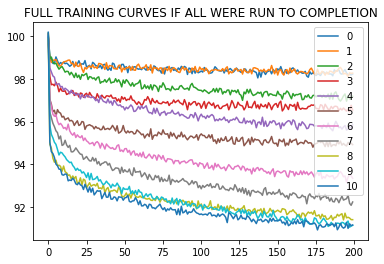

In [7]:
for curve in TRAINING_CURVES:
    plt.plot(np.arange(max_epochs), curve)
plt.legend(range(len(TRAINING_CURVES)))
plt.title("FULL TRAINING CURVES IF ALL WERE RUN TO COMPLETION")

In [8]:
# how often we want to generate a plot (total epochs run for any model)
plotting_frequency = 50

QUITTING MODEL 5
starting new model 3 on worker 2
QUITTING MODEL 3
starting new model 1 on worker 2
QUITTING MODEL 1
starting new model 7 on worker 2
QUITTING MODEL 7
starting new model 4 on worker 2
QUITTING MODEL 4
starting new model 6 on worker 2
QUITTING MODEL 6
starting new model 8 on worker 2


C:\Users\nbbwang\Anaconda2\envs\py36\lib\site-packages\numpy\lib\function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


MODEL 0 DONE
starting new model 10 on worker 1
QUITTING MODEL 8
MODEL 9 DONE
MODEL 10 DONE


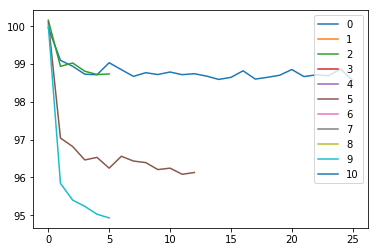

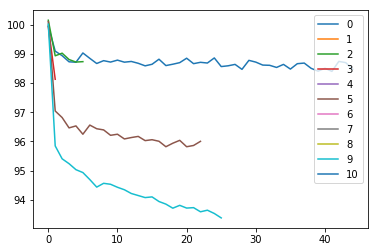

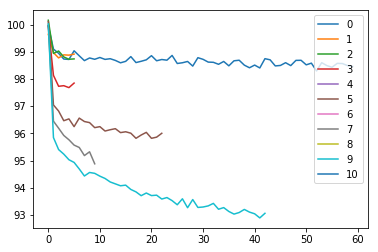

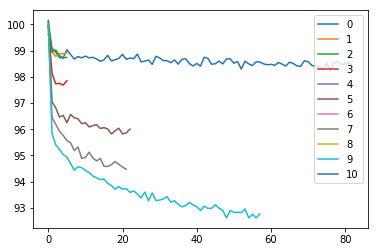

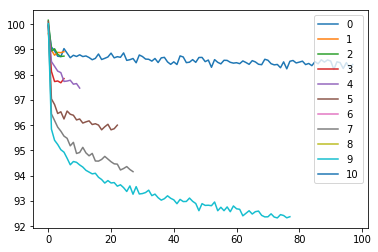

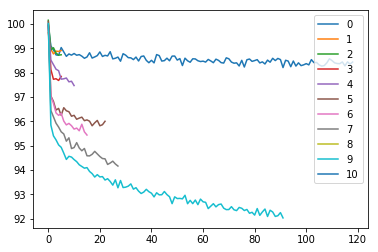

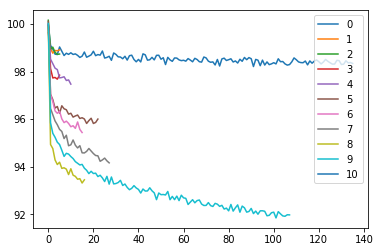

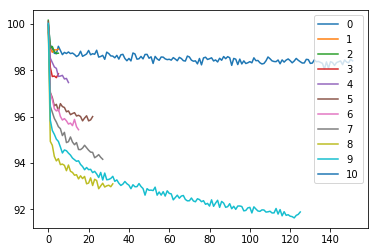

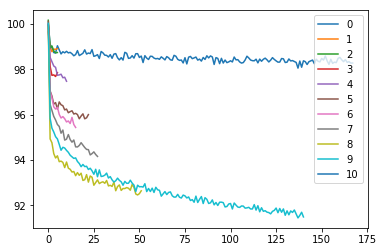

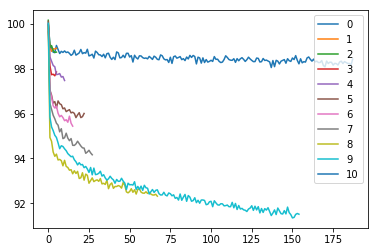

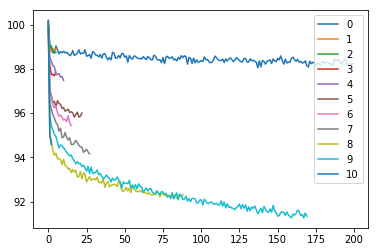

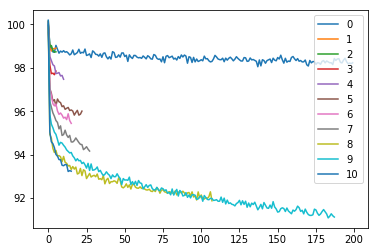

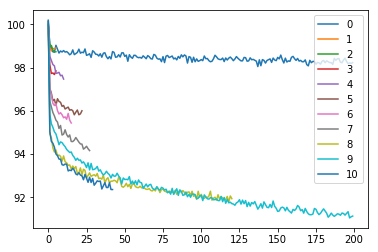

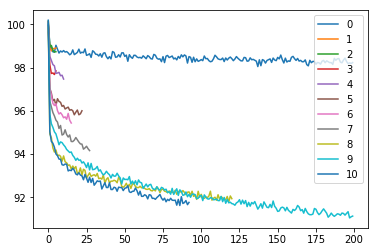

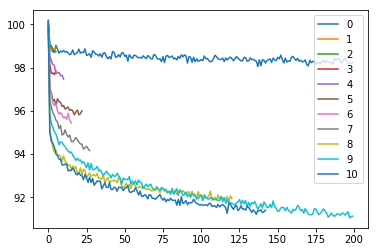

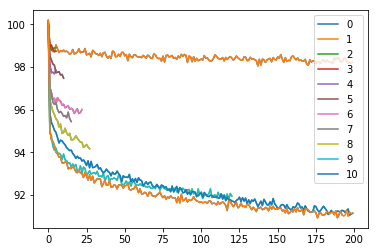

In [10]:
print_counter=0
while True: 
    # 
    if np.sum(list(ep_counters.values())) % plotting_frequency == 0 and np.sum(list(ep_counters.values())) !=0:
        if print_counter < 100:
            plt.figure()
            for row in losses:
                plt.plot(np.arange(200), row)
            plt.legend(np.arange(len(hy_list)))
            print_counter+=1
    
    # if there are no workers working on any models AND there are no models left to test, break out of the loop
    if len(np.where(~np.isnan(WORKERS))[0]) == 0 and not MODEL_QUEUE:
        break
        
    # if there are any unoccupied workers, add a new model from the queue
    while len(np.where(np.isnan(WORKERS))[0]) > 0:
        # make sure model queue isnt empty
        if MODEL_QUEUE:
            new_mod = MODEL_QUEUE.pop()
            new_worker_id = int(np.random.choice(np.where(np.isnan(WORKERS))[0]))
            print("starting new model %i on worker %i"%(new_mod, new_worker_id))
            WORKERS[new_worker_id] = new_mod   
        else:
            break

    # (FOR SIMULATION) randomly pick a non-idle worker and get the next loss   
    selected_worker = np.random.choice(np.where(~np.isnan(WORKERS))[0])
    cur_mod = int(WORKERS[selected_worker])
                  
    # pretend we're getting a message, but for the simulation, its just the next item of the training curve array
    update(ep_counters[cur_mod], cur_mod, TRAINING_CURVES[cur_mod, ep_counters[cur_mod]])
    
#     print(ep_counters[cur_mod], cur_mod, TRAINING_CURVES[cur_mod, ep_counters[cur_mod]])

    if check_stopping(cur_mod):
        print("QUITTING MODEL %i"%cur_mod)
        WORKERS[selected_worker] = np.nan

    elif (ep_counters[cur_mod] >= max_epochs-1):
        print("MODEL %i DONE"%cur_mod)
        WORKERS[selected_worker] = np.nan
        
    else:
        ep_counters[cur_mod] += 1

        
    
    
    
for row in losses:
    plt.plot(np.arange(200), row)
plt.legend(np.arange(len(hy_list)))
        